# Third project - Class: Tecnicas observacionales - 2024-I

## 1. Requirements

Run the terminal command `pip install` using the dependencies document `requirements.txt`, which contains the libraries to be installed for the notebook to work.

In [1]:
!pip install -r requirements.txt

Also, for downloading the necessary `.fits` files, follow the instructions described in [this pdf](work.pdf)

## 2. Libraries import

Import the necessary libraries and functions for further steps

In [2]:
import numpy as np

import glob

from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.utils import calc_total_error
from photutils.centroids import centroid_sources, centroid_com

from scipy.stats import mode

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy.table.table import QTable

import pandas as pd

import matplotlib.pyplot as plt

## 3. Paths definition

Write down the variables with the path to find the `.fits` and `.tsv` files and the variable with the path to save the output `.csv`.

In [3]:
#This directory must contain all the files that correspond to one of the instruments (SPITZER, WISE or MIPS).
fits_dir = './Data/MIPS/'
#This directory must contain all the file corresponding to the GAIA catalog (here is used the catalog GAIA DR2 generated using SAO image ds9).
catalog_dir = './Data/Catalogs/'
#This directory is where the output .csv is going to be saved.
output_dir = './Data/MIPS_outputs/'

## 4. Main code

### 4.1 Charge .fits files

Charge the .fits files that you have in your data directory

In [4]:

files_list = glob.glob(fits_dir + '*.fits')
names = []
for file in files_list:
    if (fits_dir in file) and (file.endswith('.fits')):
        names.append(file.replace(fits_dir,''))
        
print("Names charged in the list!")

Names charged in the list!


Let's check all our files has been charged.

In [5]:
# Printing the name of the .fits files charged.
if names != []:
    N_files = len(names)
    print(f'\n Your directory has {N_files} .fits files \n')
    for l in range(N_files):
        print(f'No. {l+1}: {names[l]}')
else: 
  print('\n Su carpeta no tiene archivos .fits \n')


 Your directory has 2 .fits files 

No. 1: SPITZER_M1_5787904_0000_10_E6047710_maic.fits
No. 2: SPITZER_M2_22963200_0000_2_E6100062_maic.fits


### 4.2 Charge the catalog file 

Charge the file with the catalog generated by SAOimage ds9

In [6]:
objects = pd.read_csv(catalog_dir+"ds9-ch2.tsv", sep='\t')
objects.head(5)

,_RAJ2000,_DEJ2000,RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Source,Plx,e_Plx,pmRA,...,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E(BP-RP),Rad,Lum
0,56.140769,31.975080,56.140796,0.3242,31.975046,0.1349,216627812425858432,2.8710,0.3193,5.223,...,16.3286,0.0644,3.6859,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,56.213663,31.986909,56.213677,0.9994,31.986910,0.4143,216629113800124544,-0.9963,0.9072,2.636,...,18.6819,0.0578,2.1048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,56.219711,32.015701,56.219736,0.1829,32.015668,0.0787,216629530412699008,3.4062,0.1702,5.053,...,14.9032,0.0045,3.6261,NaN,NaN,3496.43,2.1027,1.2005,0.58,0.046
3,56.254507,32.040566,56.254532,0.3843,32.040534,0.1582,216629732274649856,2.7968,0.3897,4.751,...,16.8323,0.0080,3.7482,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,56.267739,32.051545,56.267756,0.2295,32.051515,0.1061,216629874010076544,2.8970,0.2724,3.448,...,16.3039,0.0051,3.5550,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we are interested specifically in the Right ascension, the Declination, the Source ID, the parallax and its error, for each star. Let's extract them.

In [7]:
ra = objects["_RAJ2000"]
dec = objects["_DEJ2000"]
id_code = objects["Source"]
Plx = objects["Plx"]
e_Plx = objects["e_Plx"]

This values are in hhmmss and ggmmss, then we will convert them to degrees.

In [8]:
decimal_catalog = SkyCoord(ra, dec, unit=(u.degree))
gaia_catalog = {"_RAJ2000": decimal_catalog.ra.deg,
           "_DEJ2000": decimal_catalog.dec.deg,
           "Source": id_code,
           "Plx": Plx,
           "e_Plx": e_Plx}
gaia_catalog = pd.DataFrame(gaia_catalog)

In [9]:
gaia_catalog.head(5)

,_RAJ2000,_DEJ2000,Source,Plx,e_Plx
0,56.140769,31.975080,216627812425858432,2.8710,0.3193
1,56.213663,31.986909,216629113800124544,-0.9963,0.9072
2,56.219711,32.015701,216629530412699008,3.4062,0.1702
3,56.254507,32.040566,216629732274649856,2.7968,0.3897
4,56.267739,32.051545,216629874010076544,2.8970,0.2724


### 4.3 .FITS processing

Let's do some tests with just one of the `.fits` files.

---

First of all let's define a function that detects whether or not an object of the catalog is inside the image.

In [10]:
def is_in_pic(w, image, ra, dec):
    """
    Function that selects only the objects from the catalog that are inside the image. 
    """
    ra_max, dec_max = w.array_index_to_world_values(0,0)
    ra_min, dec_min = w.array_index_to_world_values(image.shape[0], image.shape[1])
    if ra_min > ra_max:
        ra_min = w.array_index_to_world_values(0,0)[0]
        ra_max = w.array_index_to_world_values(image.shape[0], image.shape[1])[0]
    if dec_min > dec_max:
        dec_min = w.array_index_to_world_values(0,0)[1]
        dec_max = w.array_index_to_world_values(image.shape[0], image.shape[1])[1]
    return (ra < ra_max) & (ra > ra_min) & (dec < dec_max) & (dec >   dec_min)

Let's open the `.fits` file

In [11]:
k = 0
fits_path = files_list[k]
fits_name = names[k]
print(f"""
path to the file: {fits_path},

file_name: {fits_name}
""")


path to the file: ./Data/MIPS/SPITZER_M1_5787904_0000_10_E6047710_maic.fits,

file_name: SPITZER_M1_5787904_0000_10_E6047710_maic.fits



For extracting the data necessay for future manipulation, you may print the header to know what of each of the header attributes you need.

In [12]:
with fits.open(fits_path) as FitsData:
    w = WCS(FitsData[0].header)
    image = FitsData[0].data
    fits_header = FitsData[0].header
fits_header

SIMPLE  =                    T                                                  
BITPIX  =                  -32 / -32 = 4-BYTE FLOAT, 16 = 2-BYTE INTEGER        
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                  824 / Axis 1 size                                    
NAXIS2  =                 2899 / Axis 2 size                                    
EXTEND  =                    T / TAPE MAY HAVE STANDARD FITS EXTENSIONS         
ORIGIN  = 'Spitzer Science Center' / Organization generating this FITS file     
CREATOR = 'S18.12.0'           / SW version used to create this FITS file       
TELESCOP= 'Spitzer '           / Spitzer Space Telescope                        
INSTRUME= 'MIPS    '           / Spitzer Space Telescope instrument ID          
CHNLNUM =                    1 / This image: 1=24um,2=70um,3=160um              
AOT_TYPE= 'MipsScan'           / Observation Template Type                      
AORLABEL= 'MIPSC-per2-2'    

The following variables are astronomical quantities and instrument caracteristics that are going to be necessary for the future calculus.

In [13]:
itime  = fits_header['EXPTIME'] 
ifilter = fits_header['CHNLNUM']  
DateObs = fits_header['DATE_OBS']
if ifilter == 1:
    epadu = fits_header['GAIN']
if ifilter == 2:
    epadu = 7

Writing a txt file that contains the information of the objects that are contained in the picture.

In [14]:
with open(output_dir+f"Objectlist_{fits_name}.out", "w") as NewListO:
    object_counter = 0 # object counter for the objects that are inside the image.
    for index, row in gaia_catalog.iterrows():
        condition = is_in_pic(w, image, row["_RAJ2000"], row["_DEJ2000"])
        if condition:
            object_counter +=1
            X, Y = SkyCoord(row["_RAJ2000"], row["_DEJ2000"], frame="icrs", unit="deg").to_pixel(w)
            NewListO.write(f"{row['_RAJ2000']}    {row['_DEJ2000']}    {row['Source']}   {X}   {Y} {row['Plx']} {row['e_Plx']}  {condition}\n")
print(f'\n Se han encontrado {object_counter} objetos del catálogo en el archivo .fits \n')
if object_counter == 0:
    raise ValueError("Not objects found")


 Se han encontrado 967 objetos del catálogo en el archivo .fits 



Save the coordinates from the objects of the catalog that are in the image.

In [15]:
with open(output_dir+f"Objectlist_{fits_name}.out", "r") as Obj:
    ListObj = Obj.readlines()

Final_LO = []
for obj in ListObj:
    Final_LO.append(obj.split()[:-1])
    RA, DEC, ID, x, y, Plx, e_Plx = zip(*Final_LO) 
    Final_List = np.array(list(zip(RA,DEC,x,y,Plx,e_Plx)), dtype=float)
    ID = np.array(ID,dtype='U20')


Drop the objects that are not in the fits files (just in case the is_in_pic function failed numerically)

In [16]:
mm = [ 0 < i[2] and i[2] < (image.shape[1] - 1) for i in Final_List] # List of [Booleans] (x) where the positions are inside the image.
new_ID = []
for i in range(len(mm)):
    if mm[i]:
        new_ID.append(ID[i])
ID = new_ID
Final_List = Final_List[mm]

nn = [ 0 < i[3] and i[3] < (image.shape[0] - 1) for i in Final_List] # List of [Booleans] (y) where the positions are inside the image.
new_ID = []
for i in range(len(nn)):
    if nn[i]:
        new_ID.append(ID[i])
ID = new_ID
Final_List = Final_List[nn]

# IDs repetidos se categorizan 
u, c = np.unique(ID, return_counts=True)
dup = u[c > 1]
for j in dup:
    m = 0
    for i in range(len(ID)):
        if ID[i] == j:
            m += 0.1
            ID[i] = ID[i] + str(m)


Let's print a preview of the new reduced catalog

In [17]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'    .format})
print(f"\nSu catalogo reducido es (filas {len(Final_List)}):\n ")
print("----RA---- ---DEC--- -----x-----  -----y----- -----Plx------- -----e_Plx------- -----ID-------\n")
print(Final_List[0],ID[0])
print("    ...       ...         ...          ...         ...        \n")
print(Final_List[len(Final_List)-1],ID[len(Final_List)-1])
print("---------- --------- ------------  ----------- -------------\n")


Su catalogo reducido es (filas 967):
 
----RA---- ---DEC--- -----x-----  -----y----- -----Plx------- -----e_Plx------- -----ID-------

[56.140769 31.975080 503.170925 1238.341656 2.871000 0.319300] 2.1662781242585843e+
    ...       ...         ...          ...         ...        

[55.995000 32.371425 498.446128 1848.279039 1.099100 0.756000] 2.16722576584166e+17
---------- --------- ------------  ----------- -------------



For the next step, we will calculate the pixel position of the centroid of the stars in the image. They are calculated using the [centroid_com function](https://photutils.readthedocs.io/en/stable/api/photutils.centroids.centroid_com.html), which is defined as the "center of mass".

In [18]:
# Se extraen los valores X y Y
center_box_size = 7 #boz size for the calculation of the centroid

_, _, x_init, y_init, _, _ = zip(*Final_List)

x, y = centroid_sources(image, x_init, y_init, box_size = center_box_size, centroid_func=centroid_com)
X, Y = np.array(x), np.array(y)
NewIDS = np.array(ID)

#Centroids with NaN or inf values are eliminated
is_nan = ~np.isnan(X)
x, y = X[is_nan],Y[is_nan]      
Final_List2 = Final_List[is_nan] 
NewIDS = NewIDS[is_nan]

#Resultant centroids
starloc = list(zip(x,y))

### 4.4 Photometry

We are interested in applying for the photometry both Circular aperture (for a zone encapsulating the centroid of the star) and Annulus aperture (for the zone surrounding the star, i.e., the bakcground).

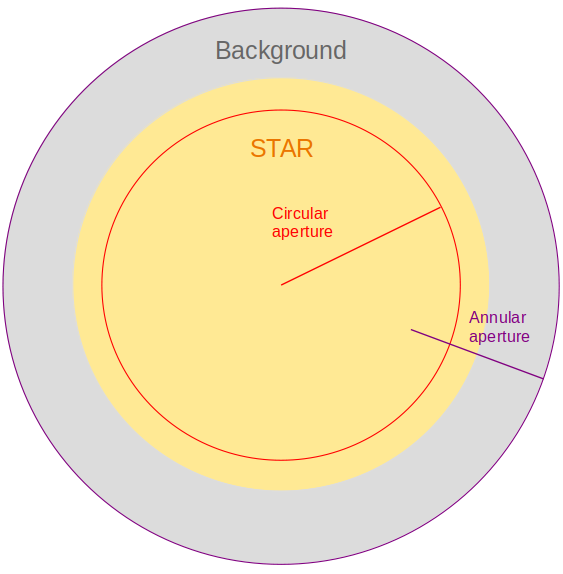

Let's define the photometric parameters (aperture, sky ring internal radius, sky ring external radius) for each star centroid.

In [19]:
r = 9 # Aperture (px)
r_in = 9 # Sky ring internal radius (px)
r_out = 20 #Sky ring external radius (px)

#Defined them as proper photometric objects using photutils.
circular_aperture = CircularAperture(starloc, r=r)
annulus_aperture = CircularAnnulus(starloc, r_in=r_in, r_out=r_out )
apers = [circular_aperture, annulus_aperture]

In [20]:
print(apers[0].shape, apers[1].shape)

(958,) (958,)


As you can see, there is a defined circular and annular aperture for each of the objects.

Let's apply both type of apertures on the photometry of the image.

In [21]:
phot_table = aperture_photometry(image, apers)

In [22]:
for index in np.argwhere(np.isnan(phot_table['aperture_sum_0'])):
    print(phot_table['aperture_sum_0'][index[0]], phot_table['aperture_sum_1'][index[0]])

nan nan
nan nan
nan nan
nan nan
nan nan


The `aperture_sum_0` corresponds to the photometry of the circular aperture, while the `aperture_sum_1` corresponds to the annular aperture photometry.

Let's calculate now the area and flux in the total area (the sum of the flux in the cirular aperture, that ideally corresponds to the star, and the annular aperture, that ideally corresponds just to the background).

In [23]:
#Area and flux in from the background
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
area_aper = np.array(circular_aperture.area_overlap(image))
bkg_sum = bkg_mean * area_aper

#Total flux from each object after substracting background
final_flux = phot_table['aperture_sum_0'] - bkg_sum

conv_fact = #From instrumental units (DN/s) to MJy/sr

phot_table['flux'] = final_flux
phot_table['flux'].info.format = '%.8g' 

By knowing which of the channels we are using from SPITZER, we will have a minimum magnitude value that can be detected by each of them. Below we have the values of the minimum magnitude of each of the channels, which will be selected depending on the `ifilter` value that is especified in the header of the `.fits` file. For our example, which selects the channel 1, `ifilter == 1` (you are free to explore with the other channel `.fits`)

In [24]:
print("channel", ifilter, "selected")
if ifilter == 1:
    zmag = 7.17 
elif ifilter == 2:
    zmag =  0.778 
print(zmag)  

channel 1 selected
7.17


Let's save this filter value as the name of the minimum magnitude.

In [25]:
name_mag = str(ifilter)
name_mag

'1'

Now, let's save the value of the magnitude measured by the instrument in our table. For this, we have the relation
\begin{equation}
m - m_{\text{ref}} = -2.5\log\left(\frac{F_{m}}{F_{\text{ref}} }\right)\\
\end{equation}

Where the $m$ is the magnitude of the star, $m_{\text{ref}}$ is the reference magnitude of the instrument, $F_m$ is the flux associated to $m$ and $F_{\text{ref}}$ to $m_{\text{ref}}$. Then, having that $F_{m} = S\cdot t_{\text{exp}}$, where S is the flux obtained in the aperture analysis of the image and $t_{\text{exp}}$ is the exposure time of the instrument, while $m_0 := 2.5 \log(F_{\text{ref}})$ is the zero point of the instrument

\begin{equation}
\begin{split}
m = \cancelto{0}{m_{\text{ref}}} - 2.5 \log(S*t) + 2.5 \log(F_{\text{ref}})\\
m = m_0 - 2.5 \,log_{10}\left(t_{\text{exp}} \cdot F_{\text{final}}\right)\\
\end{split}
\end{equation}

In [26]:
phot_table[name_mag + '_mag'] = zmag - 2.5 * np.log10(final_flux) - 2.5 * np.log10(itime)
phot_table[name_mag + '_mag'].info.format = '%.8g'  

/tmp/ipykernel_28091/396444029.py:1: RuntimeWarning: invalid value encountered in log10
  phot_table[name_mag + '_mag'] = zmag - 2.5 * np.log10(final_flux) - 2.5 * np.log10(itime)


---
#### Note:
if a message like the following is shown  

<div class="alert alert-danger">

```python
/tmp/ipykernel_31438/2448779896.py:1: RuntimeWarning: invalid value encountered in log10
  phot_table[name_mag + '_mag'] = zmag - 2.5 * np.log10(final_flux) + 2.5 * np.log10(itime)

```
</div>

We could deduce that the stars detected in the `.fits` may be close to the border (that is my guess). Let's plot the image to check this out


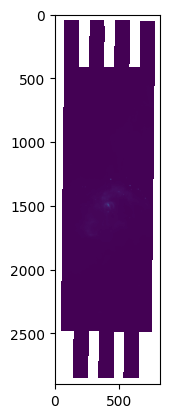

In [27]:
fig, ax = plt.subplots()
ax.imshow(image)

As the border of the .fits shows, this hypothesis may be a possibility.

#### End of the note
---

It's important to know also the uncertainties from the instrumental magnitudes. Let's save them too in our tables

In [28]:
_, _, stdev = sigma_clipped_stats(image, sigma=3.0)
phot_table[name_mag + '_mag_err'] = 1.0857 * np.sqrt(final_flux/epadu + area_aper*stdev**2 )/final_flux
phot_table[name_mag + '_mag_err'].info.format = '%.8g'

/tmp/ipykernel_28091/387041747.py:2: RuntimeWarning: invalid value encountered in sqrt
  phot_table[name_mag + '_mag_err'] = 1.0857 * np.sqrt(final_flux/epadu + area_aper*stdev**2 )/final_flux


In [29]:
n_unc_nans = np.argwhere(np.isnan(phot_table[name_mag + '_mag_err'])).shape[0]
print(f"""
# of objects with nan values in the uncertainties: {n_unc_nans}
""")


# of objects with nan values in the uncertainties: 31



Add to the table the location info, the ID, the date of observation, the object's name and the parallax with its error.

In [30]:
Final_List2

array([[56.140769, 31.975080, 503.170925, 1238.341656, 2.871000,
        0.319300],
       [56.213663, 31.986909, 411.329561, 1227.314772, -0.996300,
        0.907200],
       [56.219711, 32.015701, 391.317126, 1265.342221, 3.406200,
        0.170200],
       ...,
       [55.984382, 32.363408, 514.592141, 1841.084484, 0.763300,
        0.348400],
       [55.991048, 32.362431, 507.152214, 1837.191212, nan, nan],
       [55.995000, 32.371425, 498.446128, 1848.279039, 1.099100,
        0.756000]])

In [31]:
phot_table['RA'] = [i[0] for i in Final_List2] 
phot_table['DEC'] = [i[1] for i in Final_List2] 
phot_table['ID'] = NewIDS
phot_table['Plx'] = [i[-2] for i in Final_List2]
phot_table['e_Plx'] = [i[-1] for i in Final_List2]
phot_table['DATE-OBS'] = DateObs
if fits_header['OBJECT'] == "IC 348":
    phot_table['OBJECT'] = fits_header['OBJECT']
if fits_header['OBJECT'] == "per_m2":
    phot_table['OBJECT'] = "IC 348"
else:
    phot_table['OBJECT'] = fits_header['OBJECT']

Finally, let's drop the NaN values from the table

In [32]:
index_nan = np.argwhere(np.isnan(phot_table[name_mag + '_mag'].data)) 
phot_table.remove_rows(index_nan)

In [33]:
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,flux,1_mag,1_mag_err,RA,DEC,ID,Plx,e_Plx,DATE-OBS,OBJECT
,pix,pix,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str20,float64,float64,str23,str6
1,503.0036233686078,1238.0019498843071,10009.695327303816,38861.763075131574,141.97492,0.74371767,0.14480503,56.1407693712124,31.9750797733506,2.1662781242585843e+,2.871,0.3193,2004-09-19T14:16:16.758,IC 348
2,411.00108751687753,1226.999647691859,9879.201122060029,38900.175887164325,1.726994,5.5310197,11.429218,56.2136633685956,31.9869091934199,2.1662911380012454e+,-0.9963,0.9072,2004-09-19T14:16:16.758,IC 348
3,391.0044959510237,1265.0015794946835,9878.240649814681,38810.72852219654,23.478862,2.6975542,0.84619374,56.2197107952861,32.0157006496332,2.16629530412699e+17,3.4062,0.1702,2004-09-19T14:16:16.758,IC 348
4,338.99610677697984,1287.003652170313,9793.17993829483,38553.597074868725,3.7085807,4.7012274,5.3254931,56.2545074881102,32.0405655083321,2.1662973227464986e+,2.7968,0.3897,2004-09-19T14:16:16.758,IC 348
5,318.0005491473453,1296.9998893505933,9877.267444305064,38892.124084591385,1.8378178,5.4634906,10.740375,56.267738579543,32.0515453298481,2.1662987401007654e+,2.897,0.2724,2004-09-19T14:16:16.758,IC 348
6,311.99722270112903,1296.003634735087,9884.417243236387,38885.78633595169,10.596888,3.5613009,1.8676322,56.272601191017,32.0522027873454,2.1662986971452646e+,3.5633,0.4493,2004-09-19T14:16:16.758,IC 348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,486.9990261725339,1834.9933967851427,9755.74409684812,38393.13867565991,7.0160946,4.0090082,2.8177715,56.0070922285938,32.3651800620591,2.167196173500722e+1,-1.4141,0.6922,2004-09-19T14:16:16.758,IC 348


## 5. Apply over all .FITS

Let's put all the previous lines of code in a function for processing all the `.fits` files.

In [34]:
def Photometry_Data_Table(fits_name, fits_path, catalog, r, r_in, r_out, center_box_size, *args):
    """
    Function for
    """
    ################################################
    # Functions
    ################################################
    
    def is_in_pic(w, image, ra, dec):
        """
        Function that selects only the objects from the catalog that are inside the image. 
        """
        ra_max, dec_max = w.array_index_to_world_values(0,0)
        ra_min, dec_min = w.array_index_to_world_values(image.shape[0], image.shape[1])
        if ra_min > ra_max:
            ra_min = w.array_index_to_world_values(0,0)[0]
            ra_max = w.array_index_to_world_values(image.shape[0], image.shape[1])[0]
        if dec_min > dec_max:
            dec_min = w.array_index_to_world_values(0,0)[1]
            dec_max = w.array_index_to_world_values(image.shape[0], image.shape[1])[1]
        return (ra < ra_max) & (ra > ra_min) & (dec < dec_max) & (dec >   dec_min)

    ################################################
    # Main process
    ################################################
    
    with fits.open(fits_path) as FitsData:
        w = WCS(FitsData[0].header)
        image = FitsData[0].data
        fits_header = FitsData[0].header
        itime  = fits_header['EXPTIME'] 
        ifilter = fits_header['CHNLNUM']  
        DateObs = fits_header['DATE_OBS']
        if ifilter == 1:
            epadu = fits_header['GAIN']
            zmag = 0 #-2.5*np.log(3.73438e-11)
        elif ifilter == 2:
            epadu = 7
            zmag =  0 #-2.5*np.log(4.76327e-13)
    # Writing a txt file that contains the information of the objects that are contained in the picture.
    with open(output_dir+f"Objectlist_{fits_name}.out", "w") as NewListO:
        object_counter = 0 # object counter for the objects that are inside the image.
        for index, row in catalog.iterrows():
            condition = is_in_pic(w, image, row["_RAJ2000"], row["_DEJ2000"])
            if condition:
                object_counter +=1
                X, Y = SkyCoord(row["_RAJ2000"], row["_DEJ2000"], frame="icrs", unit="deg").to_pixel(w)
                NewListO.write(f"{row['_RAJ2000']}    {row['_DEJ2000']}    {row['Source']}   {X}   {Y} {row['Plx']} {row['e_Plx']}  {condition}\n")
    print(f'\n Found {object_counter} items from the catalog in the file {fits_name} \n')
    if object_counter == 0:
        return None
        quit()

    # Save the coordinates from the objects of the catalog that are in the image.
    with open(output_dir+f"Objectlist_{fits_name}.out", "r") as Obj:
        ListObj = Obj.readlines()

    Final_LO = []
    for obj in ListObj:
        Final_LO.append(obj.split()[:-1])
        RA, DEC, ID, x, y, Plx, e_Plx = zip(*Final_LO) 
        Final_List = np.array(list(zip(RA,DEC,x,y,Plx,e_Plx)), dtype=float)
        ID = np.array(ID,dtype='U20')

    # Drop the objects that are not in the fits files (just in case the is_in_pic function failed numerically)
    mm = [ 0 < i[2] and i[2] < (image.shape[1] - 1) for i in Final_List] # List of [Booleans] (x) where the positions are inside the image.
    ID = ID[mm]
    Final_List = Final_List[mm]
    
    nn = [ 0 < i[3] and i[3] < (image.shape[0] - 1) for i in Final_List] # List of [Booleans] (y) where the positions are inside the image.
    ID = ID[nn]
    Final_List = Final_List[nn]

    # IDs repetidos se categorizan 
    u, c = np.unique(ID, return_counts=True)
    dup = u[c > 1]
    for j in dup:
        m = 0
        for i in range(len(ID)):
            if ID[i] == j:
                m += 0.1
                ID[i] = ID[i] + str(m)
    
    # print a preview of the reduced catalog.
    np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'    .format})
    
    # Extract the X, Y values
    _, _, x_init, y_init, _, _ = zip(*Final_List)

    x, y = centroid_sources(image, x_init, y_init, box_size = center_box_size, centroid_func=centroid_com)
    X, Y = np.array(x), np.array(y)
    NewIDS = np.array(ID) 
        
    # Eliminate the data that have NaN or inf centroids.
    is_nan = ~np.isnan(X)
    x, y = X[is_nan],Y[is_nan]      
    Final_List2 = Final_List[is_nan] 
    NewIDS = NewIDS[is_nan]

    # Star coordinates centroids. 
    starloc = list(zip(x,y))
        
    # Extract each star signal.
    aperture = CircularAperture(starloc, r=r)
    annulus_aperture = CircularAnnulus(starloc, r_in=r_in, r_out=r_out )
    apers = [aperture, annulus_aperture]
    # Se genera una tabla de datos.
    phot_table = aperture_photometry(image, apers)

    # Se le asigna nombre de la magnitud dependiendo del filtro en el encabezado
    name_mag = str(ifilter)
    print("channel:", name_mag)

    # Area y fujo en los anillos. 
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    area_aper = np.array(aperture.area_overlap(image))
    bkg_sum = bkg_mean * area_aper
        
    # Flujo final para cada objeto
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['flux'] = final_sum
    phot_table['flux'].info.format = '%.8g'  
        
    # Magnitudes Instrumentales
    phot_table[name_mag + '_mag'] = zmag - 2.5 * np.log10(final_sum) + 2.5 * np.log10(itime)
    phot_table[name_mag + '_mag'].info.format = '%.8g'  
        
    # Error de las Magnitudes Instrumentales
    mean, median, std = sigma_clipped_stats(image, sigma=3.0)
    stdev = std
    phot_table[name_mag + '_mag_err'] = 1.0857 * np.sqrt(final_sum    /epadu + area_aper*stdev**2 )/final_sum
    phot_table[name_mag + '_mag_err'].info.format = '%.8g'

    # Se agrega a la tabla la RA, DEC, ID y Masa de aire. 
    phot_table['RA'] = [i[0] for i in Final_List2] 
    phot_table['DEC'] = [i[1] for i in Final_List2] 
    phot_table['ID'] = NewIDS
    phot_table['Plx'] = [i[-2] for i in Final_List2] 
    phot_table['e_Plx'] = [i[-1] for i in Final_List2] 
    
    phot_table['DATE-OBS'] = DateObs
    if fits_header['OBJECT'] == "IC 348":
        phot_table['OBJECT'] = fits_header['OBJECT']
    if fits_header['OBJECT'] == "per_m2":
        phot_table['OBJECT'] = "IC 348"
    else:
        phot_table['OBJECT'] = fits_header['OBJECT']
    # Se buscan los indices en donde las magnitudes sean NaN y se eliminan
    index_nan = np.argwhere(np.isnan(phot_table[name_mag + '_mag'].data)) 
    phot_table.remove_rows(index_nan)
    total_rows = len(phot_table)
    print(f"\nAfter the analysis there are {total_rows} objects processed in the {fits_name} file\n\n ################################################################################################################################################\n\n")
    return phot_table

Here we add a line to ignore the warnings of the NaN values, because they are dropped in the final steps of the function.

In [35]:
import warnings
warnings.filterwarnings("ignore") #for the nan values that are then drop in the final steps.

Let's put the previous photometric parameters here again (aperture, sky ring internal radius, sky ring external radius) for each star centroid.

In [36]:
#########################################
# Definición de parámetros fotométricos #
#########################################
r = 14
r_in = 14
r_out = 22
print(r, r_in, r_out)
#########################################
# Let's save the tables for all the fits files
all_tables = []
for k in range(len(files_list)):
  fits_path = files_list[k]
  fits_name = names[k]
#  catalogo = catalogo_final

  photom = Photometry_Data_Table(fits_name, fits_path, gaia_catalog, r=r, r_in=r_in, r_out=r_out, center_box_size=center_box_size)
  if photom is not None:
    all_tables.append(photom)

print(f'{len(all_tables)} tables from the .fits files were generated')

14 14 22

 Found 967 items from the catalog in the file SPITZER_M1_5787904_0000_10_E6047710_maic.fits 

channel: 1

After the analysis there are 401 objects processed in the SPITZER_M1_5787904_0000_10_E6047710_maic.fits file

 ################################################################################################################################################



 Found 967 items from the catalog in the file SPITZER_M2_22963200_0000_2_E6100062_maic.fits 

channel: 2

After the analysis there are 433 objects processed in the SPITZER_M2_22963200_0000_2_E6100062_maic.fits file

 ################################################################################################################################################


2 tables from the .fits files were generated


Let's save the objects that are centered in each of the .fits files processed. 

**Note:** If you have only have .fits files corresponding to one object, like "IC358" for example, then that is the only name that is going to be saved in the focus_object list. 

In [37]:
#----#  List with all the main objects that are centered by the telescope.
focus_object = []             
for m in all_tables:
    ob = m['OBJECT'][0]
    if ob not in focus_object:
        focus_object.append(ob) 
#----#  Dictionary with each observed object.
final_filter = {}
for s in focus_object:
    final_filter[s] = []        # Example: filtro_final = {'SA98':[], 'SA95':[], '[BSA98':[], 'SA101':[], '[ASA98':[], 'SA104':[], 'SA92':[]}

#----#  Fill the dictionary with the table of each object.
for n in all_tables:
    for p in focus_object:
        ob = n['OBJECT'][0]
        if ob == p:
            final_filter[ob].append(n.copy())  # Example: filtro_final = {'SA98':[tabla1,tabla2,tabla3,..], ... , 'SA92':[tabla1,tabla2,tabla3,..]}

Now, let's check that we have the same objects observed in each .fits file and eliminate those which are not in all the filters.

In [38]:
#----#  Intersection of the objects in the different filters.
for foc in focus_object:
    current_id = []
    for j in final_filter[foc]:
        current_id.append(j['ID'].data)

    int_d = set(current_id[0]).intersection(*current_id) # Ejemplo para SA98: int_d = {'92_248', ... , '92_347'}

#----#  Delete the objects that are not in all the filters
for tab in final_filter[foc]:
    index_of = []
    for i in range(len(tab['ID'])):
        if tab['ID'][i] not in int_d:
            index_of.append(i)
    tab.remove_rows(index_of)

#----# Delete the void tables.
for p in focus_object:
    if len(final_filter[p][0]) == 0:
        del final_filter[p]

for foc in final_filter.keys():
    let = len(final_filter[foc])

Finally, let's create and save the tables for each object.

In [39]:
#----# Create the tables for each main object.
for foc in final_filter.keys():
    print(foc)
    final_obs_table = pd.DataFrame()
    final_obs_table['OBJECT_ID'] = final_filter[foc][0]['ID']
    final_obs_table['RA'] = final_filter[foc][0]['RA']
    final_obs_table['DEC'] = final_filter[foc][0]['DEC']
    final_obs_table['Plx'] = final_filter[foc][0]['Plx']
    final_obs_table['e_Plx'] = final_filter[foc][0]['e_Plx']
    #----# Save the tables as .csv files.
    for j in final_filter[foc]:
        final_obs_table[j.colnames[6]] = j[j.colnames[6]]
        final_obs_table[j.colnames[7]] = j[j.colnames[7]]
        final_obs_table[j.colnames[-2] + '_' + j.colnames[6]] = j[j.colnames[-2]]
    final_obs_table.to_csv(output_dir+f'/Table_{foc}_r_{r}_ranul_{r_in}_{r_out}.csv')   
final_obs_table

IC 348


,OBJECT_ID,RA,DEC,Plx,e_Plx,1_mag,1_mag_err,DATE-OBS_1_mag,2_mag,2_mag_err,DATE-OBS_2_mag
0,2.16629530412699e+17,56.219711,32.015701,3.4062,0.1702,-3.367618,0.530593,2004-09-19T14:16:16.758,-6.342950,0.271736,2008-03-12T14:30:58.575
1,2.1663014459149683e+,56.255887,32.083816,3.0209,0.0756,-3.701209,0.391241,2004-09-19T14:16:16.758,-5.716674,0.483623,2008-03-12T14:30:58.575
2,2.1665351351006003e+,56.318102,32.105531,3.2664,0.1341,-7.308067,0.017400,2004-09-19T14:16:16.758,-6.221121,0.303978,2008-03-12T14:30:58.575
3,2.1665361658833344e+,56.261586,32.095548,NaN,NaN,-4.279018,0.231349,2004-09-19T14:16:16.758,-7.116772,0.133344,2008-03-12T14:30:58.575
4,2.166536165879694e+1,56.262097,32.097506,-0.0080,2.1382,-4.567226,0.178291,2004-09-19T14:16:16.758,-7.041328,0.142924,2008-03-12T14:30:58.575
...,...,...,...,...,...,...,...,...,...,...,...
222,2.1671937683176742e+,56.044728,32.345229,NaN,NaN,-2.993665,0.747190,2004-09-19T14:16:16.758,-5.323465,0.694596,2008-03-12T14:30:58.575
223,2.1671937683189414e+,56.044687,32.346602,1.0520,0.5904,-2.508313,1.166191,2004-09-19T14:16:16.758,-5.311475,0.702306,2008-03-12T14:30:58.575
224,2.1671965600520064e+,56.035558,32.365692,1.7657,1.6530,0.999094,29.400792,2004-09-19T14:16:16.758,-7.002218,0.148159,2008-03-12T14:30:58.575
225,2.1671969036614144e+,56.036788,32.370990,1.1947,0.5001,-3.859398,0.338712,2004-09-19T14:16:16.758,-7.068356,0.139415,2008-03-12T14:30:58.575


Printing one of the saved .csv (we are going to show the last one saved), you can see that it saves the magnitude, uncertainty of the magnitude and the date of observation of each of the objects for all the channels that you had in the fits. files.

In [40]:
final_obs_table

,OBJECT_ID,RA,DEC,Plx,e_Plx,1_mag,1_mag_err,DATE-OBS_1_mag,2_mag,2_mag_err,DATE-OBS_2_mag
0,2.16629530412699e+17,56.219711,32.015701,3.4062,0.1702,-3.367618,0.530593,2004-09-19T14:16:16.758,-6.342950,0.271736,2008-03-12T14:30:58.575
1,2.1663014459149683e+,56.255887,32.083816,3.0209,0.0756,-3.701209,0.391241,2004-09-19T14:16:16.758,-5.716674,0.483623,2008-03-12T14:30:58.575
2,2.1665351351006003e+,56.318102,32.105531,3.2664,0.1341,-7.308067,0.017400,2004-09-19T14:16:16.758,-6.221121,0.303978,2008-03-12T14:30:58.575
3,2.1665361658833344e+,56.261586,32.095548,NaN,NaN,-4.279018,0.231349,2004-09-19T14:16:16.758,-7.116772,0.133344,2008-03-12T14:30:58.575
4,2.166536165879694e+1,56.262097,32.097506,-0.0080,2.1382,-4.567226,0.178291,2004-09-19T14:16:16.758,-7.041328,0.142924,2008-03-12T14:30:58.575
...,...,...,...,...,...,...,...,...,...,...,...
222,2.1671937683176742e+,56.044728,32.345229,NaN,NaN,-2.993665,0.747190,2004-09-19T14:16:16.758,-5.323465,0.694596,2008-03-12T14:30:58.575
223,2.1671937683189414e+,56.044687,32.346602,1.0520,0.5904,-2.508313,1.166191,2004-09-19T14:16:16.758,-5.311475,0.702306,2008-03-12T14:30:58.575
224,2.1671965600520064e+,56.035558,32.365692,1.7657,1.6530,0.999094,29.400792,2004-09-19T14:16:16.758,-7.002218,0.148159,2008-03-12T14:30:58.575
225,2.1671969036614144e+,56.036788,32.370990,1.1947,0.5001,-3.859398,0.338712,2004-09-19T14:16:16.758,-7.068356,0.139415,2008-03-12T14:30:58.575
